# Ghibli and Flickr Scrapper

This script is meant to generate an image dataset in order to train a CycleGAN model to produce Ghibli styled images out of real word photos.

There are three main parts:
1. Get movies images from ghibli.jp
2. Using the tumblr API to get random real-world image
3. Generate tfrec files to use with TensorFlow


In [9]:
from PIL import Image
import requests
from io import BytesIO
import os
from os import path
import matplotlib.pyplot as plt

import tensorflow as tf


In [26]:
response = requests.get("https://www.ghibli.jp/gallery/thumb-karigurashi001.png")
img = Image.open(BytesIO(response.content))

Width= 300 , Height= 162


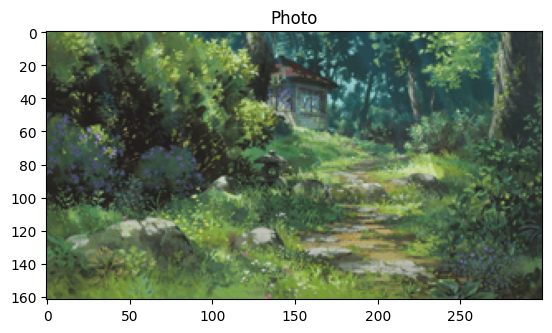

In [10]:
plt.title('Photo')
plt.imshow(img)

w, h = img.size
print("Width=", w, ", Height=", h)

Getting more images

In [60]:
def scrape_movie(movie_name, max=0, details=False):
    response = requests.Response()
    img_index = 1

    tfrec_file_name = f"ghibli_tfrec/{movie_name}_small.tfrec"
    # Get all images
    while response.status_code != 404 and (max==0 or img_index <= max):
        if(details):
            print("Getting Image", img_index)
        
        file_name = f"ghibli_jpg/{movie_name}_small_{img_index:03}.jpg"
        if path.exists(file_name):
            print("Image already exists, skipping.")

        url = f"https://www.ghibli.jp/gallery/thumb-{movie_name}{img_index:03}.png"
        if(details):
            print(url)
        
        
        response = requests.get(url)
        if response.status_code != 404:
            img = response.content
            with open(file_name, 'wb') as f:
                f.write(img)
            img_index += 1

            # Add image to tfrec
            # with tf.io.TFRecordWriter(tfrec_file_name) as writer:
            #     features = {
            #         'image_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[img_index])),
            #         'image': tf.train.Feature(bytes_list = tf.train.BytesList(value = [img]))}
                
            #     example = tf.train.Example(features = tf.train.Features(feature = features))
            #     writer.write(example.SerializeToString())

    # Show result
    if img_index == 1:
        print(f"📛 Movie not found: {movie_name}.")
    else:
        print(f"✅ Job Done, found and saved {img_index-1} images for {movie_name}.") # Seems like this counts 1 extra image..

In [17]:
scrape_movie("test")
# scrape_movie("karigurashi")

📛 Movie not found: test.


In [61]:
movies = [
    # 'karigurashi',
    # 'howl',
    # 'chihiro',
    # 'mononoke',
    # 'mimi',
    # 'porco',
    # 'majo',
    # 'totoro',
    # 'onyourmark',
    # 'redturtle'
    "nausicaa",
    "laputa",
    "omoide",
    "umi",
    "tanuki",
    "baron",
    "ged",
    "kokurikozaka",
    "kazetachinu",
    "marnie",
]

for m in movies:
    scrape_movie(m)

✅ Job Done, found and saved 50 images for nausicaa.
✅ Job Done, found and saved 50 images for laputa.
✅ Job Done, found and saved 50 images for omoide.
✅ Job Done, found and saved 50 images for umi.
✅ Job Done, found and saved 50 images for tanuki.
✅ Job Done, found and saved 50 images for baron.
✅ Job Done, found and saved 50 images for ged.
✅ Job Done, found and saved 50 images for kokurikozaka.
✅ Job Done, found and saved 50 images for kazetachinu.
✅ Job Done, found and saved 50 images for marnie.


# Get Random Photos

We also need a dataset made of random real-world images.
We'll use the flickr API for that.

In [53]:
import flickrapi

flickr_api_key = u'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
api_secret = u'yyyyyyyyyyyyyyyy'

flickr = flickrapi.FlickrAPI(api_key=flickr_api_key, secret=api_secret)

keyword = 'siberian husky'

# photos = flickr.photos.getRecent(extras='url_c')
photos = flickr.data_walker(flickr.photos.getRecent, extras='url_n')

urls = []
for i, photo in enumerate(photos):

    url = photo.get('url_n')
    id = photo.get('id')
    urls.append((id,url))



In [55]:
def add_image_to_dataset(id, url):
    if url == None:
        return 0
    response = requests.get(url)
    if response.status_code != 404:
        file_name = f"photo_tmp/photo_{id}.jpg"

        img = response.content
        with open(file_name, 'wb') as f:
            f.write(img)
        return 1
    return 0
def generate_tfrec(tfrec_file_name="photo_tfrec/photos.tfrec"):
    directory = 'photo_jpg'

    for filename in os.listdir(directory):
        f = path.join(directory, filename)
        # checking if it is a file
        if path.isfile(f):
            id = int(filename.split('_')[1].split('.')[0])
            with open(f, 'rb') as image:
                img = image.read()
                with tf.io.TFRecordWriter(tfrec_file_name) as writer:
                    features = {
                        'image_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(id)])),
                        'image': tf.train.Feature(bytes_list = tf.train.BytesList(value = [img]))
                    }
                    example = tf.train.Example(features = tf.train.Features(feature = features))
                    writer.write(example.SerializeToString())
            



In [57]:
added_photos = 0
for (id,url) in urls:
    added_photos += add_image_to_dataset(id, url)
print(f"✅ Sucsessfully added {added_photos} photos.")

KeyboardInterrupt: 

In [20]:
#generate_tfrec()

# TFRecords

We need to generate the TFRecords now that we have our images

In [44]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )

def bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))



def create_example(image, file_name):
    feature = {
        'file_name': bytes_feature(str.encode(file_name)),
        'image': image_feature(image)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# num_samples is the number of data samples on each TFRecord file.
def create_tfrec(image_type, num_samples=64):
    image_folder_path = f"{image_type}_jpg"

    if not os.path.exists(image_folder_path):
        print(f"Error: wrong image type ({image_folder_path} not found)")
        return 1
    
    tfrec_folder_path = f"{image_type}_tfrec"

    if not os.path.exists(tfrec_folder_path):
        os.makedirs(tfrec_folder_path)
    
    images = []
    for file in os.listdir(image_folder_path):
        if file.endswith('.jpg'):
            images.append(file)

    num_images = len(images)
    num_tfrecords = num_images // num_samples
    if num_images % num_samples:
        num_tfrecords += 1

    for tfrec_num in range(num_tfrecords):
        samples = images[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]

        with tf.io.TFRecordWriter(
            tfrec_folder_path + "/%s_%.2i-%i.tfrec" % (image_type,tfrec_num, len(samples))
        ) as writer:
            for sample in samples:
                image_path = f"{image_folder_path}/{sample}"
                image = tf.io.decode_jpeg(tf.io.read_file(image_path))
                example = create_example(image, sample)
                writer.write(example.SerializeToString())


In [62]:
create_tfrec("ghibli", num_samples=128)
create_tfrec("photo", num_samples=128)